In [1]:
import os
import platform
from pathlib import Path

from sc2.main import run_replay
from sc2.observer_ai import ObserverAI
import asyncio
import json
import signal
import sys
from contextlib import suppress
from dataclasses import dataclass
from io import BytesIO
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
from sc2.sc2process import SC2Process, kill_switch
from sc2.client import Client

import mpyq
from sc2.portconfig import Portconfig
from aiohttp import ClientSession, ClientWebSocketResponse
from s2clientprotocol import sc2api_pb2 as sc_pb
from sc2.game_state import GameState
from sc2.data import CreateGameError, Result, Status

class ObserverBot(ObserverAI):
    """
    A replay bot that can run replays.
    Check sc2/observer_ai.py for more available functions
    """

    async def on_start(self):
        print("Replay on_start() was called")

    async def on_step(self, iteration: int,gs, proto_game_info):
        print(f"Replay iteration: {iteration}")
        # print(gs)


def get_replay_version(replay_path: Union[str, Path]) -> Tuple[str, str]:
    with open(replay_path, 'rb') as f:
        replay_data = f.read()
        replay_io = BytesIO()
        replay_io.write(replay_data)
        replay_io.seek(0)
        archive = mpyq.MPQArchive(replay_io).extract()
        metadata = json.loads(archive[b"replay.gamemetadata.json"].decode("utf-8"))
        return metadata["BaseBuild"], metadata["DataVersion"]

async def runReplay(replay_path, ai, realtime, _portconfig, base_build, data_version, observed_id):
    async with SC2Process(fullscreen=False, base_build=base_build, data_hash=data_version) as server:
        client = await _setup_replay(server, replay_path, realtime, observed_id)
        game_data = await client.get_game_data()
        game_info = await client.get_game_info()
        ping_response = await client.ping()
        while True:
            
            if realtime:
                state = await client.observation(gs.game_loop + client.game_step)
            else:
                state = await client.observation()
            
            gs = GameState(state.observation)
            logger.debug(f"Score: {gs.score.score}")
            proto_game_info = await client._execute(game_info=sc_pb.RequestGameInfo())
            # print(f"game_loop : {gs.game_loop}\n{gs.player_result}\n{gs.common.minerals}\n{gs.visibility}")
            if not realtime:
                if not client.in_game:  # Client left (resigned) the game
                    return Result.Victory

            await client.step()
            
async def debugReplay(replay_path, ai, realtime, _portconfig, base_build, data_version, observed_id):
    async with SC2Process(fullscreen=False, base_build=base_build, data_hash=data_version) as server:
        client = await _setup_replay(server, replay_path, realtime, observed_id)
        game_data = await client.get_game_data()
        game_info = await client.get_game_info()
        ping_response = await client.ping()
        while True:
            
            cmd=input()
            resp=eval(cmd)
            print(resp)
            await asyncio.sleep(1)

async def _setup_replay(server, replay_path, realtime, observed_id):
    await server.start_replay(replay_path, True, observed_id)
    return Client(server._ws)

In [2]:
import skvideo.io
import win32process
import numpy as np
import win32gui
import psutil
from PIL import Image,ImageGrab
def closeclient():
    hwnd = win32gui.FindWindow(None,'《星际争霸II》')
    win32gui.CloseWindow(hwnd)
    
def closepkill():
  hwnd = win32gui.FindWindow(None,'《星际争霸II》')
  pid = win32process.GetWindowThreadProcessId(hwnd)
  for i in pid:
      try:
          psutil.Process(i).kill()
      except:
          print(i)
def grab():
  hwnd = win32gui.FindWindow(None,'《星际争霸II》')
  a,b,c,d= win32gui.GetWindowRect(hwnd)
  image=ImageGrab.grab((a+8,b+32,c-8,d-8))
  return np.array(image)

In [3]:
from sc2.ids.unit_typeid import UnitTypeId
from sc2.ids.ability_id import AbilityId

async def genrateJson(file,observed_id):
    writer = skvideo.io.FFmpegWriter(f"videos/{os.path.basename(file).split('.')[0]} {observed_id}.mp4",outputdict={"-r": str(25)})
    
    my_observer_ai = ObserverBot()
    abilid={}
    for i in AbilityId:
        abilid[i.value]=i.name
    tuid={}
    for i in UnitTypeId:
        tuid[i.value]=i.name
    portconfig = Portconfig()
    base_build, data_version = get_replay_version(file)
    server= await SC2Process(fullscreen=False, base_build=base_build, data_hash=data_version).__aenter__()
    interval=100
    try:
        client = await _setup_replay(server, file, False, observed_id)
    except Exception as e:
        print(file)
        return 

    
    data={'preloops':[],'loops':[],'cameras':[]}
    while True:
        try:
            await client.step(int(interval*0.95))
        except Exception as e:
            print("Done!")
            break
        state = await client._execute(observation=sc_pb.RequestObservation())
        a = state.observation.observation.raw_data
        ll=[]
        for i in a.units:
            if i.is_on_screen and i.display_type==1:
                tmp={
                    'pos':(i.pos.x,i.pos.y),
                    'radius':i.radius,
                    'type':tuid[i.unit_type],
                    'tag':i.tag,
                }
                ll.append(tmp)
        data['preloops'].append(ll)
        try:
            await client.step(int(interval*0.05))
        except Exception as e:
            print("Done!")
            break
        state = await client._execute(observation=sc_pb.RequestObservation())
        a = state.observation.observation.raw_data
        data['cameras'].append((a.player.camera.x,a.player.camera.y))
        ll=[]
        units=[]
        for i in a.units:
            tmp={
                    'pos':(i.pos.x,i.pos.y),
                    'tag':i.tag,
                }
            units.append(tmp)
        for i in a.units:
            if i.is_on_screen and i.display_type==1:
                oo=[]
                if i.orders:
                    for order in i.orders:
                        tt={}
                        if order.target_unit_tag:
                            tt['id']=abilid[order.ability_id]
                            tt['target']=order.target_unit_tag
                        elif order.target_world_space_pos:
                            for j in units:
                                if j['pos']==(order.target_world_space_pos.x,order.target_world_space_pos.y):
                                    tt['id']=abilid[order.ability_id]
                                    tt['target']=j['tag']
                        else:
                            tt['id']=abilid[order.ability_id]
                            tt['target']=-1
                        oo.append(tt)
                tmp={
                    'pos':(i.pos.x,i.pos.y),
                    'radius':i.radius,
                    'type':tuid[i.unit_type],
                    'fly' :i.is_flying,
                    'tag':i.tag,
                    'orders':oo
                }
                ll.append(tmp)
        writer.writeFrame(grab())
        
        data['loops'].append(ll)
    writer.close()
    print(len(data['preloops']),len(data['loops']))
    if len(data['preloops'])>len(data['loops']):
        data['preloops'].pop()
    
    data['preloops'].pop()
    data['loops'].pop()
    data['cameras'].pop()
        
    
    game_data = await client._execute(replay_info=sc_pb.RequestReplayInfo(replay_path=file))
    # T:1 Z:2 P:3
    race=game_data.replay_info.player_info[observed_id-1].player_info.race_actual
    data['race']= race
    with open(f'sgg\\apidata\\{os.path.basename(file).split(".")[0]} {observed_id}.json', 'w') as f:
        json.dump(data, f)
    await server._process.__aexit__()
    closeclient()
    closepkill()

In [4]:
import nest_asyncio
import json


observed_id=1
cnt=0
for file in os.listdir('./replay/Playoffs/'):
    if cnt==23:
        break
    cnt+=1
    replay_path = f"E:\\proj_sc2\\replay\\playoffs\\{file}"
    
    if  not os.path.exists(f'sgg\\apidata\\{file.split(".")[0]} {observed_id}.json'):
        await genrateJson(replay_path,observed_id)
    await asyncio.sleep(3)
    if  not os.path.exists(f'sgg\\apidata\\{file.split(".")[0]} {3-observed_id}.json'):
        await genrateJson(replay_path,3-observed_id)
    


2023-01-11 20:25:54.006 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.in_replay (was None)
2023-01-11 20:25:54.028 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.in_replay (was None)
2023-01-11 20:26:19.329 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.ended (was Status.in_replay)
Done!
105 104
2023-01-11 20:26:19.938 | INFO     | sc2.sc2process:_close_connection:231 - Closing connection at 51143...
2023-01-11 20:26:19.939 | INFO     | sc2.sc2process:kill_all:33 - kill_switch: Process cleanup for 1 processes
908984
2023-01-11 20:26:34.967 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.in_replay (was None)
2023-01-11 20:26:34.989 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.in_replay (was None)
2023-01-11 20:27:00.949 | INFO     | sc2.protocol:_execute:72 - Client status changed to Status.ended (was Status.in_replay)
Done!
105 104
2023-01-11 20:27:01.577 | INF

In [5]:
closepkill()

0
2143773664


In [3]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import skvideo.io

def calcposi(x,y,a,b,fly=False,d=24,s=0.8):
    return ((a-x)/d*800+400-(20*s if fly else 0),(b-y)/d*539+279+(30*s if fly else 0))
    # return ((a-x)/d*636+318-(20 if fly else 0),(b-y)/d*474+237+(30 if fly else 0))
# M=cv2.getPerspectiveTransform(np.float32([[376,89],[505,125],[193,364],[455,288]]),np.float32([[377,132],[503,166],[212,363],[437,306]]))
M=cv2.getPerspectiveTransform(np.float32([[261,404],[466,103],[611,145],[592,345]]),np.float32([[268,373],[477,104],[636,143],[583,326]]))

def draw(img,bb,M=M,scaler=48):
    img=cv2.warpPerspective(img,M,img.shape[1::-1])
    fig=plt.imshow(img)
    fig.axes.set_axis_off()
    for i in bb:
        fig.axes.add_patch(plt.Rectangle(xy=(i[0]-i[2]*scaler//2,(540-i[1]-i[2]*scaler//2-10)),height=i[2]*scaler+10,width=i[2]*scaler+10,color='red',linewidth=1,fill=False))

In [7]:
# M=cv2.getPerspectiveTransform(np.float32([[269,368],[477,104],[636,143],[555,303]]),np.float32([[261,415],[466,104],[611,145],[558,331]]))
# M=cv2.getPerspectiveTransform(np.float32([[261,415],[466,104],[611,145],[558,331]]),np.float32([[269,368],[477,104],[636,143],[555,303]]))

def draw(img,bb,M=M,scaler=48):
    fig=plt.imshow(img)
    fig.axes.set_axis_off()
    for i in bb:
        foo=np.dot(M,np.array(i[:2]+[1]))
        i[:2]=foo[:2]/foo[2]
        fig.axes.add_patch(plt.Rectangle(xy=(i[0]-2,526-i[1]),height=4,width=4,color='red',linewidth=1,fill=True))

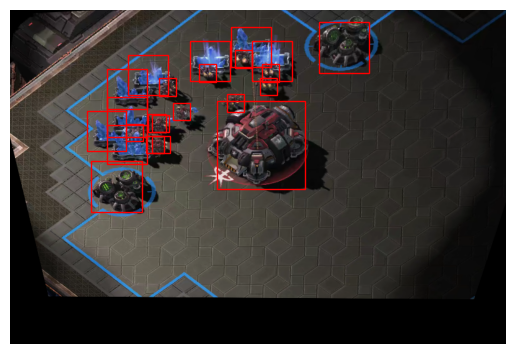

In [4]:
videodata = skvideo.io.vread('videos/1 - Ro24 - Bunny vs trigger - TvP - G1 - Cosmic Sapphire 1.mp4')
jsonfilepath='sgg/apidata/1 - Ro24 - Bunny vs trigger - TvP - G1 - Cosmic Sapphire 1.json'
with open(jsonfilepath,'r') as f:
    data=json.load(f)
bbox=[]
idx=5
for u in data['loops'][idx]:
    # print(calcposi(*data['cameras'][idx],*u['pos'],u['fly']))
    bbox.append([*calcposi(*data['cameras'][idx],*u['pos'],u['fly']),u['radius'],u['type']])
    # bbox.append([*calcposi(*data['cameras'][idx],*np.dot(M,np.array(u['pos']+[1]))[:2],u['fly']),u['radius'],u['type']])
draw(videodata[idx],bbox)

In [6]:
class gData():
    def __init__(self):
        self.objects=[]
        self.relationships=[]
        self.attributes=[]
        self.synset={}
        self.image_data=[]
        self.image_id=0
        self.num_obj=0
        self.num_rel=0
        self.h=539
        self.w=800    
    def encodeJsonData(self,videopath,jsonfilepath,objthres=5):
        videodata = skvideo.io.vread(videopath)
        with open(jsonfilepath,'r') as f:
            data=json.load(f)
       
        def warpimage(img,idx):
            # M=cv2.getPerspectiveTransform(np.float32([[376,89],[505,125],[193,364],[455,288]]),np.float32([[377,132],[503,166],[212,363],[437,306]]))
            M=cv2.getPerspectiveTransform(np.float32([[261,404],[466,103],[611,145],[592,345]]),np.float32([[268,373],[477,104],[636,143],[583,326]]))
            
            img=cv2.warpPerspective(img,M,img.shape[1::-1])
            cv2.imwrite(f'sgg/images/{idx}.jpg',img)
        for idx in range(len(data['loops'])):
            if len(data['loops'][idx])<=objthres:
                continue
            self.image_id+=1
            self.image_data.append(
                {"width": self.w, "url": None, "height": self.h, "image_id": self.image_id, "coco_id": None, "flickr_id": None}
            )
            warpimage(videodata[idx],self.image_id)
            cnt_obj=0
            objs=[]
            rels=[]
            attris=[]
            tag2id={}
            gid2id={}
            image_url=f'images/{self.image_id}.jpg'
            preposi={}
            for u in data['preloops'][idx]:
                preposi[u['tag']]=u['pos']
            for u in data['loops'][idx]:
                attri=[]
                self.num_obj+=1
                cnt_obj+=1
                a,b=calcposi(*data['cameras'][idx],*u['pos'],u['fly'])
                x,y,h,w=int(a-u['radius']*24),int(self.h-b-10-u['radius']*24),int(u['radius']*48+10),int(u['radius']*48+10)
                objs.append({
                    'synsets'   : [u['type']+'.n.01'],
                    'h'         : h,
                    'w'         : w,
                    'x'         : x,    
                    'y'         : y,   
                    "object_id" : self.num_obj,
                    "merged_object_ids": [],
                    "names": [u['type']]
                })
                if u['radius']<0.5:
                    attri.append('small')
                elif u['radius']>1.5:
                    attri.append('huge')
                if u['tag'] in preposi :
                    if u['pos']!=preposi[u['tag']]:
                        attri.append('moving')
                    else:
                        attri.append('stand by')
                attris.append({
                    'synsets'   : [u['type']+'.n.01'],
                    'h'         : h,
                    'w'         : w,
                    'x'         : x,    
                    'y'         : y,   
                    "object_id" : self.num_obj,
                    "merged_object_ids": [],
                    "names": [u['type']],
                    'attributes':attri
                })      
                tag2id[u['tag']]=cnt_obj-1
                gid2id[self.num_obj]=cnt_obj-1
            tmp={
                'image_id':self.image_id,
                'objects':objs,
                'image_url':None
            }
            self.objects.append(tmp)
            tmp={
                'image_id':self.image_id,
                'attributes':attris
            }
            self.attributes.append(tmp)
            for i in attris:
                for attr in i['attributes']:
                    self.num_rel+=1
                    rel={"predicate": attr, 
                            "subject": objs[gid2id[i['object_id']]] ,
                            "relationship_id": self.num_rel, 
                            "synsets": ["attri"+'.n.01'], 
                            "object": objs[gid2id[i['object_id']]]}
                    rels.append(rel)
            
            for i in range(len(objs)):
                objs[i]['name']=objs[i]['names'][0]
            for u in data['loops'][idx]:
                for order in u['orders']:
                    if not order:
                        
                        break
                    if 'HARVEST_GATHER' in order['id']:
                        if order['target'] in tag2id:
                            self.num_rel+=1
                            rel={"predicate": "mining", 
                            "subject": objs[tag2id[u['tag']]], 
                            "relationship_id": self.num_rel, 
                            "synsets": ["mining"+'.n.01'], 
                            "object": objs[tag2id[order['target']]]}
                    if 'HARVEST_RETURN' in order['id']:
                        if order['target'] in tag2id:
                            self.num_rel+=1
                            rel={"predicate": "deliver", 
                            "subject": objs[tag2id[u['tag']]], 
                            "relationship_id": self.num_rel, 
                            "synsets": ["mining"+'.n.01'], 
                            "object": objs[tag2id[order['target']]]}
                    if 'ATTACK' in order['id']:
                        if order['target'] in tag2id:
                            self.num_rel+=1
                            rel={"predicate": "attack", 
                            "subject": objs[tag2id[u['tag']]], 
                            "relationship_id": self.num_rel, 
                            "synsets": ["attack"+'.n.01'], 
                            "object": objs[tag2id[order['target']]]}
                    if 'TERRANBUILD' in order['id']:
                        if order['target'] in tag2id:
                            self.num_rel+=1
                            rel={"predicate": "build", 
                            "subject": objs[tag2id[u['tag']]], 
                            "relationship_id": self.num_rel, 
                            "synsets": ["build"+'.n.01'], 
                            "object": objs[tag2id[order['target']]]}
                    try:
                        rels.append(rel)
                    except:
                        print(order)
            tmp={
                'relationships':rels,
                'image_id':self.image_id
            }
            self.relationships.append(tmp)

In [7]:

vdir='videos\\'
jsondir='sgg\\apidata\\'
foobar=gData()
for file in os.listdir(jsondir):
    foobar.encodeJsonData(vdir+file[:-4]+'mp4',jsondir+file)

with open(f'sgg\\objects.json', 'w') as f:
    json.dump(foobar.objects, f)
with open(f'sgg\\attributes.json', 'w') as f:
    json.dump(foobar.attributes, f)
with open(f'sgg\\relationships.json', 'w') as f:
    json.dump(foobar.relationships, f)
with open(f'sgg\\image_data.json', 'w') as f:
    json.dump(foobar.image_data, f)

In [8]:
import json
with open('sgg/objects.json','r') as f:
    objs=json.load(f)
with open('sgg/relationships.json','r') as f:
    rels=json.load(f)
synsets={}
objsdict=set()
for img in objs:
    for o in img['objects']:
        objsdict.add(o['names'][0])
        if o['names'][0] not in synsets:
            synsets[o['names'][0]]=o['synsets'][0]
with open('sgg/object_list.txt','w') as f:
    for i in list(objsdict):
        f.write(i+'\n')
with open('sgg/object_alias.txt','w') as f:
    pass
relsdict=set()
for img in rels:
    for r in img['relationships']:
        relsdict.add(r['predicate'])
        if r['predicate'] not in synsets:
            synsets[r['predicate']]=o['synsets'][0]
with open('sgg/predicate_list.txt','w') as f:
    for i in list(relsdict):
        f.write(i+'\n')
with open('sgg/predicate_alias.txt','w') as f:
    pass
with open('sgg/attribute_synsets.json','w') as f:
    json.dump(synsets,f)
            

In [7]:
import matplotlib.pyplot as plt
for n,i in enumerate(skvideo.io.vread('videos/10 - Ro16 - Scarlett vs NightMare - PvZ - G2 - Inside and Out 2.mp4')):

    plt.imsave(f'testimg/3{n}.jpg',i)
    